In [1]:
import numpy as np
import tensorflow as tf
import vgg16
from scipy.misc import imread, imresize, imsave, imshow
import matplotlib.pyplot as plt

%matplotlib inline

# Generated Image

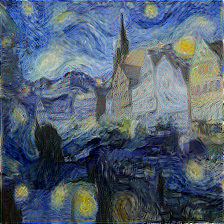

In [2]:
from IPython.display import Image

#  This is the Image after 4900 epochs
Image("/home/tuna/Projects/CS501r_Deep_Learning/lab10/generated_im_4900.png")

# Model

In [3]:
sess = tf.Session()

opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                        dtype=tf.float32,
                                        stddev=1e-1), name='opt_img' )

tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )

vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )

style_img = imread( 'style.png', mode='RGB' )
style_img = imresize( style_img, (224, 224) )
style_img = np.reshape( style_img, [1,224,224,3] )

content_img = imread( 'content.png', mode='RGB' )
content_img = imresize( content_img, (224, 224) )
content_img = np.reshape( content_img, [1,224,224,3] )

layers = [ 'conv1_1', 'conv1_2',
           'conv2_1', 'conv2_2',
           'conv3_1', 'conv3_2', 'conv3_3',
           'conv4_1', 'conv4_2', 'conv4_3',
           'conv5_1', 'conv5_2', 'conv5_3' ]

ops = [ getattr( vgg, x ) for x in layers ]



generated_acts = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1,
                 vgg.conv5_1]


content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )


#
# --- construct your cost function here
#


#  content loss
content_loss = tf.nn.l2_loss(vgg.conv4_2 - content_acts[8])



#  style loss
w = 1.0 / 5.0
E_layers = []

#  for every relevant style layer
for index, i in enumerate([0,2,4,7,10]):

    N = style_acts[i].shape[3]
    M = style_acts[i].shape[1] * style_acts[i].shape[2]
    E_const_mult = 1.0/(4.0 * N**2 * M**2)



    F_l = tf.reshape(style_acts[i], ([M,N]))
    gram_Al = tf.matmul(F_l, F_l, transpose_a = True)
    #  gram matrix should be NxN


    F_l = tf.reshape(generated_acts[index], ([M,N]))
    gram_Gl = tf.matmul(F_l, F_l, transpose_a = True)

    El = E_const_mult * tf.nn.l2_loss(gram_Gl - gram_Al)
    E_layers.append(El)


style_loss = w * tf.reduce_sum(E_layers)


#  combined loss
alpha = 1.0
beta = 10000.0
loss = alpha * content_loss + beta * style_loss




# Relevant snippets from the paper:
#   For the images shown in Fig 2 we matched the content representation on layer 'conv4_2'
#   and the style representations on layers 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1' and 'conv5_1'
#   The ratio alpha/beta was  1x10-3
#   The factor w_l was always equal to one divided by the number of active layers (ie, 1/5)

# --- place your adam optimizer call here
#     (don't forget to optimize only the opt_img variable)
learning_rate = 0.5
optim = tf.train.AdamOptimizer(learning_rate, epsilon=0.1).minimize(loss, var_list=[opt_img])


# # this clobbers all VGG variables, but we need it to initialize the
# # adam stuff, so we reload all of the weights...
sess.run( tf.initialize_all_variables() )
vgg.load_weights( 'vgg16_weights.npz', sess )

# initialize with the content image
sess.run( opt_img.assign( content_img ))



# --- place your optimization loop here
#  run 5000 iterations 
num_epochs = 5000
for i in range(num_epochs):

    new_img = sess.run(opt_img)
    new_img = tf.clip_by_value(new_img , 0.0, 255.0 )
    sess.run(opt_img.assign(new_img))
    new_img = sess.run(opt_img)[0]
    new_img = new_img.clip(0.0, 255.0)
    (_, content_l, style_l, total_l) = sess.run([optim, content_loss, style_loss, loss])
    print ("Content loss: " + str(content_l) + ", Style loss: " + str(style_l) + ", Total loss: " + str(total_l))

    if i % 100 == 0:
        imsave('generated_im_' + str(i) + '.png', new_img)



(0, 'conv1_1_W', (3, 3, 3, 64))
(1, 'conv1_1_b', (64,))
(2, 'conv1_2_W', (3, 3, 64, 64))
(3, 'conv1_2_b', (64,))
(4, 'conv2_1_W', (3, 3, 64, 128))
(5, 'conv2_1_b', (128,))
(6, 'conv2_2_W', (3, 3, 128, 128))
(7, 'conv2_2_b', (128,))
(8, 'conv3_1_W', (3, 3, 128, 256))
(9, 'conv3_1_b', (256,))
(10, 'conv3_2_W', (3, 3, 256, 256))
(11, 'conv3_2_b', (256,))
(12, 'conv3_3_W', (3, 3, 256, 256))
(13, 'conv3_3_b', (256,))
(14, 'conv4_1_W', (3, 3, 256, 512))
(15, 'conv4_1_b', (512,))
(16, 'conv4_2_W', (3, 3, 512, 512))
(17, 'conv4_2_b', (512,))
(18, 'conv4_3_W', (3, 3, 512, 512))
(19, 'conv4_3_b', (512,))
(20, 'conv5_1_W', (3, 3, 512, 512))
(21, 'conv5_1_b', (512,))
(22, 'conv5_2_W', (3, 3, 512, 512))
(23, 'conv5_2_b', (512,))
(24, 'conv5_3_W', (3, 3, 512, 512))
(25, 'conv5_3_b', (512,))
(0, 'conv1_1_W', (3, 3, 3, 64))
(1, 'conv1_1_b', (64,))
(2, 'conv1_2_W', (3, 3, 64, 64))
(3, 'conv1_2_b', (64,))
(4, 'conv2_1_W', (3, 3, 64, 128))
(5, 'conv2_1_b', (128,))
(6, 'conv2_2_W', (3, 3, 128, 128))
(7, '

# Display Current Image

In [41]:
# display the final image
foo = sess.run( opt_img )

#  use scipy's imshow?

#  need to scale between 0,1 possibly
# plt.imshow(foo.squeeze())
imshow(foo.squeeze())

In [42]:
foo = sess.run( opt_img )


imsave('generated_im.png', foo.squeeze())
